# [Part 1] Understanding U.S. Electricity Consumption: Weather & Seasonal Only Modeling
### Parametric vs. Nonparametric Approaches Using Weather & Seasonal Features

### **[Project Summary]**
  - **Research Question:**\
  To what extent can U.S. electricity consumption be explained using only weather and seasonal features, and how do parametric and nonparametric models differ in interpretability and predictive performance?
  - **Goal**:
    - Evaluate both parametric (GLM) and nonparametric (Random Forest) models to compare interpretability and predictive capability.
    - Identify the key weather and seasonal factors that influence electricity consumption.
  - **Data**:
    - National Centers for Environment information (NCEI) - Weather Features
    - U.S. Energy Information Administration (EIA) - Residential Energy Consumption
  - **Key Results**:
    - Electricity consumption is affected by weather and seasonal patterns, but the relationship is nonlinear, resulting in limited performance for GLMs and significantly better results from Random Forest.
    - Temperature is the most influential weather feature affecting electricity consumption, while wind speed, PMDI, and precipitation have relatively weaker impacts.
    - Weather and Seasonal features alone explain electricity consumption only up to around $R^2$ = 0.67, indicating that they provide meaningful insight but cannot fully capture consumption patterns on their own.
  - **Tech Stack**:\
  Python, Pandas, Numpy, Scikit-learn (RandomForest, TimeSeriesSplit, RandomizedSearchCV), statsmodels (GLM: Gaussian, Gamma), Evaluation Metrics (RMSE, $R^2$), Matplotlib, Seaborn

- **Project Outline**
  1. Data Explore and Preprocessing
  2. Feature Engineering
  3. Exploratory Data Analysis
  4. Parametric: Gaussina GLM
  5. Parametric: Gamma GLM
  6. Nonparametric: RandomForestRegressor
  7. Deeper insight to Average Temperature


# Imports


Import all required libraries for data preprocessing, visulization, model training, and interpretation.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# 1. Data Load & Cleaning

Load and clean six datasets (4 weathers and 2 electricity) to ensure consistent structure and prepare for merging.

In [ ]:
# precipitation
pr = pd.read_csv("../data/raw/Precipitation (2001-2023).csv")
# Average Temperature
at = pd.read_csv("../data/raw/Average Temperature (2001-2023).csv")
# PMDI
di = pd.read_csv("../data/raw/Palmer Modified Drought Index (2001-2023).csv")
# Wind speed
wind = pd.read_csv("../data/raw/Wind Speed Data.csv")
# Electricity (consumption)
el1 = pd.read_csv("../data/raw/Monthly-States-Table RESIDENTIAL Sales (Consumption) 1990-2009.csv")
el2 = pd.read_csv('../data/raw/Monthly-States-Table RESIDENTIAL Sales (Consumption) 2010-2025.csv')

## 1.1. Weather Data
All four weather datasets include year, month, and state.

Created a preprocessing function to clean and reshape weather datasets based on Date.

In [4]:
def weather_preprocess(df, weather_variable):
  df["Year"] = df["Date"].astype(str).str[:4].astype(int)
  df["Month"] = df["Date"].astype(str).str[4:].astype(int)
  df = df.drop("Date", axis = 1)
  cols = ["Year", "Month", "state", weather_variable]
  df = df[cols]
  df = df.sort_values(by=["state","Year", "Month"]).reset_index()
  df = df.drop("index", axis=1)
  return df

### 1.1.1. Precipitation

Total monthly precipitation (in inches) by state, year, and month.

In [5]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13800 entries, 0 to 13799
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  13800 non-null  int64  
 1   state                 13800 non-null  object 
 2   precipitation (inch)  13800 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 323.6+ KB


In [6]:
pr = weather_preprocess(pr, "precipitation (inch)")

In [7]:
pr.head()

,Year,Month,state,precipitation (inch)
0,2001,1,AK,4.54
1,2001,2,AK,3.03
2,2001,3,AK,2.47
3,2001,4,AK,2.34
4,2001,5,AK,2.27


In [8]:
print(f"number of columns including null: {(pr.isnull().sum()>0).sum()}")

number of columns including null: 0


In [9]:
print(f"number of duplicated records: {pr.duplicated().sum()}")

number of duplicated records: 0


In [10]:
pr.describe()

,Year,Month,precipitation (inch)
count,13800.00000,13800.000000,13800.000000
mean,2012.00000,6.500000,3.208613
std,6.63349,3.452178,2.084997
min,2001.00000,1.000000,0.000000
25%,2006.00000,3.750000,1.600000
50%,2012.00000,6.500000,2.960000
75%,2018.00000,9.250000,4.422500
max,2023.00000,12.000000,20.600000


### 1.1.2. Average Temperature

Monthly Average temperature (in Fahrenheit) by year, month, and state.

In [11]:
at.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13800 entries, 0 to 13799
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     13800 non-null  int64  
 1   state                    13800 non-null  object 
 2   average temperature (F)  13800 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 323.6+ KB


In [12]:
at = weather_preprocess(at, "average temperature (F)")
at = at.rename(columns={"average temperature (F)": "avg temp (F)"})

In [13]:
at.head()

,Year,Month,state,avg temp (F)
0,2001,1,AK,15.7
1,2001,2,AK,14.7
2,2001,3,AK,12.0
3,2001,4,AK,25.1
4,2001,5,AK,32.7


In [14]:
print(f"number of columns including null: {(at.isnull().sum()>0).sum()}")

number of columns including null: 0


In [15]:
print(f"number of duplicated records: {at.duplicated().sum()}")

number of duplicated records: 0


In [16]:
at.describe()

,Year,Month,avg temp (F)
count,13800.00000,13800.000000,13800.000000
mean,2012.00000,6.500000,52.830181
std,6.63349,3.452178,17.811118
min,2001.00000,1.000000,-12.800000
25%,2006.00000,3.750000,39.400000
50%,2012.00000,6.500000,54.400000
75%,2018.00000,9.250000,67.600000
max,2023.00000,12.000000,89.200000


### 1.1.3. Palmer Modified Drought Index (PMDI)

Long term indicator relative dryness or wetness.

- Negative values indicate dry conditions, while positive values indicate wet conditions.

In [17]:
di.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13800 entries, 0 to 13799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    13800 non-null  int64  
 1   state   13800 non-null  object 
 2   PMDI    13248 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 323.6+ KB


In [18]:
di = weather_preprocess(di, "PMDI")

In [19]:
di.head()

,Year,Month,state,PMDI
0,2001,1,AK,NaN
1,2001,2,AK,NaN
2,2001,3,AK,NaN
3,2001,4,AK,NaN
4,2001,5,AK,NaN


In [20]:
print(f"number of columns including null: {(di.isnull().sum()>0).sum()}")
di.isnull().sum()

number of columns including null: 1


,0
Year,0
Month,0
state,0
PMDI,552


In [21]:
missing_state = di[di["PMDI"].isnull()]["state"].unique()
print(f"State with missing values: {missing_state}")

State with missing values: ['AK' 'HI']


In [22]:
print(f"number of duplicated records: {di.duplicated().sum()}")

number of duplicated records: 0


In [23]:
di.describe()

,Year,Month,PMDI
count,13800.00000,13800.000000,13248.000000
mean,2012.00000,6.500000,0.138143
std,6.63349,3.452178,2.601739
min,2001.00000,1.000000,-9.090000
25%,2006.00000,3.750000,-1.660000
50%,2012.00000,6.500000,0.160000
75%,2018.00000,9.250000,1.940000
max,2023.00000,12.000000,10.750000


### 1.1.4. Wind Speed

Measured in miles per hour (MPH)
- Dataset does not cotain year/month specific observations
- Only long term monthly averages (1984-2023) are available from NCEI.
- A Date column was added to align this dataset with the others for merging.

In [24]:
wind = wind.rename(columns={"State":"state"})

In [25]:
wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13800 entries, 0 to 13799
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       13800 non-null  int64  
 1   state      13800 non-null  object 
 2   WindSpeed  13800 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 323.6+ KB


In [26]:
wind = weather_preprocess(wind,"WindSpeed")

In [27]:
wind.head()

,Year,Month,state,WindSpeed
0,2001,1,AK,4.0
1,2001,2,AK,4.0
2,2001,3,AK,4.0
3,2001,4,AK,3.9
4,2001,5,AK,3.9


In [28]:
print(f"number of columns including null: {(wind.isnull().sum()>0).sum()}")

number of columns including null: 0


In [29]:
print(f"number of duplicated records: {wind.duplicated().sum()}")

number of duplicated records: 0


In [30]:
wind.describe()

,Year,Month,WindSpeed
count,13800.00000,13800.000000,13800.000000
mean,2012.00000,6.500000,3.834500
std,6.63349,3.452178,1.126359
min,2001.00000,1.000000,1.800000
25%,2006.00000,3.750000,3.200000
50%,2012.00000,6.500000,3.700000
75%,2018.00000,9.250000,4.400000
max,2023.00000,12.000000,11.800000


### **[Weahter Datasets Basics]**
 - All datasets contain 13800 rows, each with Year, Month, State, and corresponding Weather Variable.
 - Time Period: 2001-2023.
 - Only PMDI has missing values, specifically for Alaska and Hawaii.
 - There are no duplicate records within any of the datasets.

## 1.2. Residential Electricity Consumption (Target Variable)

The electricity consumption datasets include expenditures (in thousand dollars) and total residential consumption (in Megawatthours) for each year, month, and state.
- For this project, total residential consumption is used as the target variable, since the primary goal is to understand how weather and seasonal features influence electricity consumption.
- Using total consumption is clearer and less confounded measure than expenditures, which can be affected by price changes.
- Past Dataset (el1) : 1990-2009
- Current Dataset (el2) : 2010-2025

Created a function that clean and reshape electricity dataset.

In [31]:
def electricity_preprocess(df):
  df = df[["Year","Month","State","Megawatthours"]].copy()
  df['Megawatthours'] = df["Megawatthours"].str.replace(',', '').astype(float)
  df['Megawatthours'] = df["Megawatthours"].astype(int)
  df = df.sort_values(by=["State", "Year", "Month"]).reset_index()
  df = df.drop("index", axis=1)
  return df

In [32]:
el1 = electricity_preprocess(el1)
el2 = electricity_preprocess(el2)

In [33]:
el = pd.concat([el1, el2], axis=0, ignore_index=True)

Prepared the electricity data for merging.

In [34]:
el = el[(el["Year"]>=2001) & (el["Year"]<=2023)]
el = el[el['State']!="DC"]

In [35]:
el = el.reset_index()
el = el.drop(columns="index", axis=1)

In [36]:
el = el.rename(columns={'State':'state'})

In [37]:
el.head()

,Year,Month,state,Megawatthours
0,2001,1,AK,206108
1,2001,2,AK,175443
2,2001,3,AK,161376
3,2001,4,AK,155222
4,2001,5,AK,139193


In [38]:
el.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13800 entries, 0 to 13799
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           13800 non-null  int64 
 1   Month          13800 non-null  int64 
 2   state          13800 non-null  object
 3   Megawatthours  13800 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 431.4+ KB


In [39]:
print(f"number of columns including null: {(el.isnull().sum()>0).sum()}")

number of columns including null: 0


In [40]:
print(f"number of duplicated records: {el.duplicated().sum()}")

number of duplicated records: 0


In [41]:
el.describe()

,Year,Month,Megawatthours
count,13800.00000,13800.000000,1.380000e+04
mean,2012.00000,6.500000,2.309874e+06
std,6.63349,3.452178,2.419743e+06
min,2001.00000,1.000000,1.281530e+05
25%,2006.00000,3.750000,6.107502e+05
50%,2012.00000,6.500000,1.701520e+06
75%,2018.00000,9.250000,3.094878e+06
max,2023.00000,12.000000,2.248142e+07


### **[Electricity Dataset Basics]**

- The data originally covered the period from 1990 to 2025, but were changed to 2001 to 2023 to aligh with the time range of the weather datsets for merging
- The dataset contains 13800 rows, each with Year, Month, State, and corresponding residential electricity consumption in MWh.
- There are no columns with missing values.
- There are no duplicate records in the dataset.

## 1.3. Merge Data

Merged all weather and electricity datasets on year, month and state keys to create a final dataset for model training and testing.

In [42]:
merged = at.copy()
for df in [pr, di, wind, el]:
  merged = merged.merge(df, on=["Year", "Month", "state"], how="left")

In [43]:
merged.head()

,Year,Month,state,avg temp (F),precipitation (inch),PMDI,WindSpeed,Megawatthours
0,2001,1,AK,15.7,4.54,NaN,4.0,206108
1,2001,2,AK,14.7,3.03,NaN,4.0,175443
2,2001,3,AK,12.0,2.47,NaN,4.0,161376
3,2001,4,AK,25.1,2.34,NaN,3.9,155222
4,2001,5,AK,32.7,2.27,NaN,3.9,139193


In [44]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13800 entries, 0 to 13799
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  13800 non-null  int64  
 1   Month                 13800 non-null  int64  
 2   state                 13800 non-null  object 
 3   avg temp (F)          13800 non-null  float64
 4   precipitation (inch)  13800 non-null  float64
 5   PMDI                  13248 non-null  float64
 6   WindSpeed             13800 non-null  float64
 7   Megawatthours         13800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 862.6+ KB


# 2. Feature Engineering

## 2.1. Handling Missing Values in PMDI

PMDI values were missing for Alaska and Hawaii across the full datasets, and both states show fundamentally different climate patterns from the mainland.
- To maintain consistency and comparability, both Alaska and Hawaii were excluded.

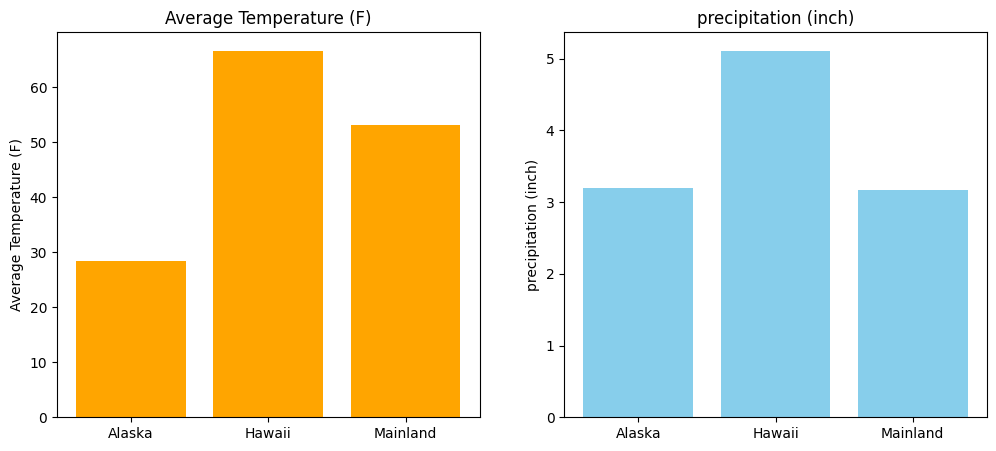

In [45]:
missing_df = merged.copy()
missing_df["region"] = missing_df["state"].apply(lambda x: "Alaska" if x == "AK" else ("Hawaii" if x == "HI" else "Mainland"))

mean_weather = missing_df.groupby("region")[["avg temp (F)","precipitation (inch)"]].mean().reset_index()

fig, axes = plt.subplots(1,2,figsize=(12, 5))
axes[0].bar(mean_weather["region"], mean_weather["avg temp (F)"], color="orange")
axes[0].set_title("Average Temperature (F)")
axes[0].set_ylabel("Average Temperature (F)")

axes[1].bar(mean_weather["region"], mean_weather["precipitation (inch)"], color="skyblue")
axes[1].set_title("precipitation (inch)")
axes[1].set_ylabel("precipitation (inch)")

plt.show()

In [46]:
merged = merged.dropna().reset_index().drop(columns="index",axis=1)
merged_len  = len(merged)
print(f"We have {merged["state"].nunique()} states after dropping Hawaii and Alaska")
print(f"We have dropped {13800-merged_len} records, and now have {merged_len} records")

We have 48 states after dropping Hawaii and Alaska
We have dropped 552 records, and now have 13248 records


**[Decision]**

- Dropped records for Hawaii and Alaska
  - PMDI is designed for mainland climate systems and does not include measuremnts for Hawaii and Alaska.
  - Alaska has a subpolar and Hawaii has a tropical climate. Their mean weather patterns show that Hawaii has higher temperatures and heavy precipitation, while Alaska has much lower temperatures compared to the mainland.
- Now, the dataset contains 48 states with 13248 records.


## 2.2. Seasonality

Created a seasonal feature by mapping months into four seasons (Winter, Spring, Summer, Fall) to capture broad seasonal effects in a simple and interpretable way.

In [47]:
season = {12:"Winter",1:"Winter",2:"Winter",
          3:"Spring",4:"Spring",5:"Spring",
          6:"Summer",7:"Summer",8:"Summer",
          9:"Fall",10:"Fall",11:"Fall"}

In [48]:
merged["season"] = merged["Month"].map(season)

## 2.3. Cyclic Encoding for Month

- Mathematical way to represent seasonality
  - month_sin = Sin(2 * pi * month / 12)
  - month_cos = Cos(2 * pi * month / 12)
- Sine and cosine together give each month a unique coordinate while preserving cyclical structure.
- Prevents treating months as linear values, which would incorrectly assume December and January are far apart.

In [49]:
merged["month_sin"] = np.sin(2*np.pi*merged["Month"]/12)
merged["month_cos"] = np.cos(2*np.pi*merged["Month"]/12)

## 2.4. Electricity Unit Conversion: MWh to GWh

Converted from Megawatthours (MWh) to Gigawatthours (GWh) to improve numerical stability and make values easier to interpret.

In [50]:
merged.loc[:,"electricity (gwh)"] = merged["Megawatthours"]*0.001

# 3. Exploratory Data Analysis (EDA)

- Explored electricity consumption trends over time.
- Examined seasonal and monthly patterns.
- Analyzed relationships between features and target to understand suitability of parametric vs. nonparametric models.


In [51]:
data = merged.copy()

## 3.1. Electricity Consumption Trends
Examined electricity consumption over time provides insight into how energy consumption evolves across years.
- long term patterns: gradual increases
- short term anomalies: sudden changes due to extraordinary events


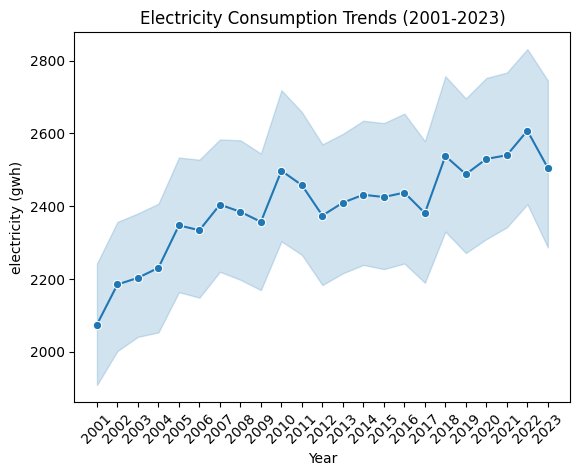

In [52]:
sns.lineplot(x="Year", y="electricity (gwh)", data = data, estimator="mean", marker = 'o')
plt.xticks(ticks=data["Year"].unique(), rotation=45)
plt.title("Electricity Consumption Trends (2001-2023)")
plt.show()

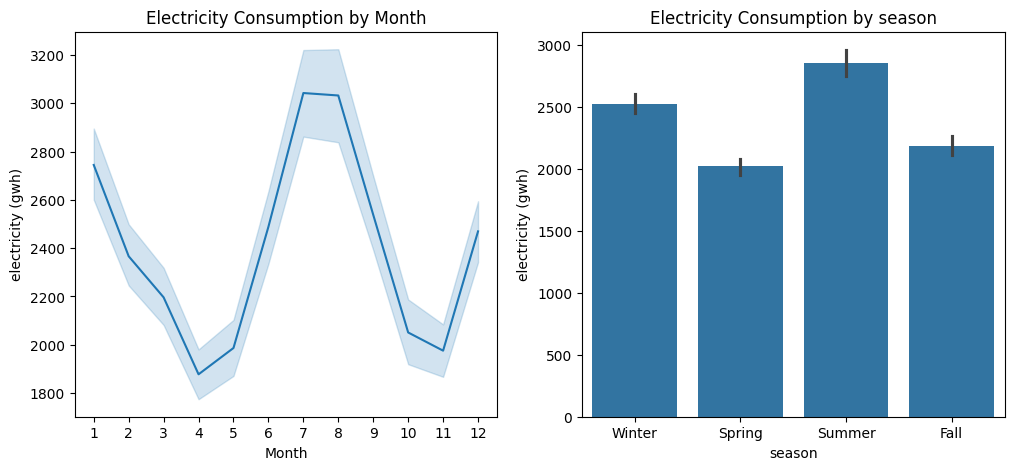

In [53]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.lineplot(x="Month", y="electricity (gwh)", data = data, estimator="mean", ax=axes[0])
axes[0].set_xticks(ticks=data["Month"].unique())
axes[0].set_title("Electricity Consumption by Month")

sns.barplot(x="season", y = "electricity (gwh)", data=data, estimator="mean",ax=axes[1])
axes[1].set_title("Electricity Consumption by season")
plt.show()

**[Observation]**

- Although electricity consumption shows a long term upward trend, several short term fluctuations are observed, likely reflecting external factors such as policy changes, economic conditions, or unusual weather events.

- Consumption tends to peak during summer and winter, likely due to increased use of heating and cooling systems. This motivates including seasonal features, as electricity consumption follows a clear cyclic patterns.

## 3.2. Monthly Weather Trends
Analyze monthly patterns of each weather feature and compare them with electricity consumption.

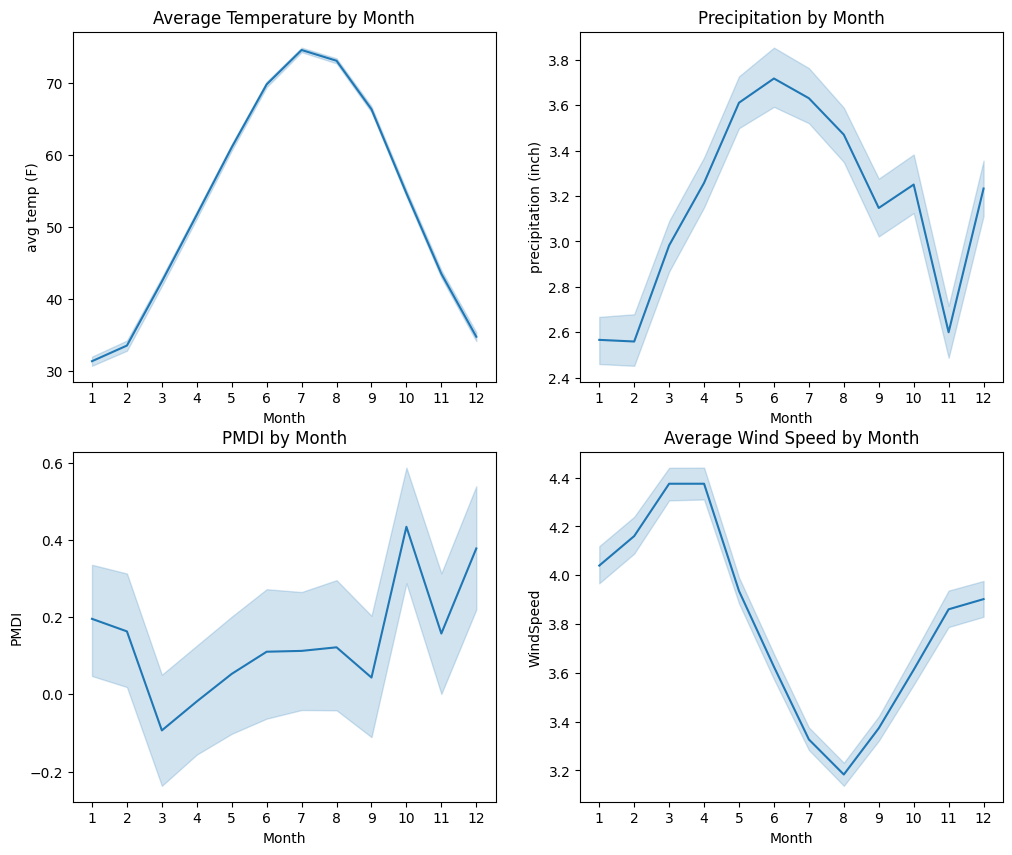

In [54]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.flatten()

sns.lineplot(x="Month", y="avg temp (F)", data = data, estimator="mean", ax=axes[0])
axes[0].set_xticks(ticks=data["Month"].unique())
axes[0].set_title("Average Temperature by Month")

sns.lineplot(x="Month", y="precipitation (inch)", data = data, estimator="mean", ax=axes[1])
axes[1].set_xticks(ticks=data["Month"].unique())
axes[1].set_title("Precipitation by Month")

sns.lineplot(x="Month", y='PMDI', data = data, estimator="mean",ax=axes[2])
axes[2].set_xticks(ticks=data["Month"].unique())
axes[2].set_title("PMDI by Month")

sns.lineplot(x="Month", y="WindSpeed", data = data, estimator="mean",ax=axes[3])
axes[3].set_xticks(ticks=data["Month"].unique())
axes[3].set_title("Average Wind Speed by Month")
plt.show()

**[Observation]**
- Weahter features show distinct seasonal patterns, indicating meaningful impact on electricity consumption.
- However, their seasonal patterns differ from electricity consumption trends, indicating that weather alone may not be sufficient to fully explain electricity consumption.


## 3.3 Weather Features Vs. Electricity Consumption

To further investigate how each weather feature affects consumption, scatterplots are used to examine their relationships.


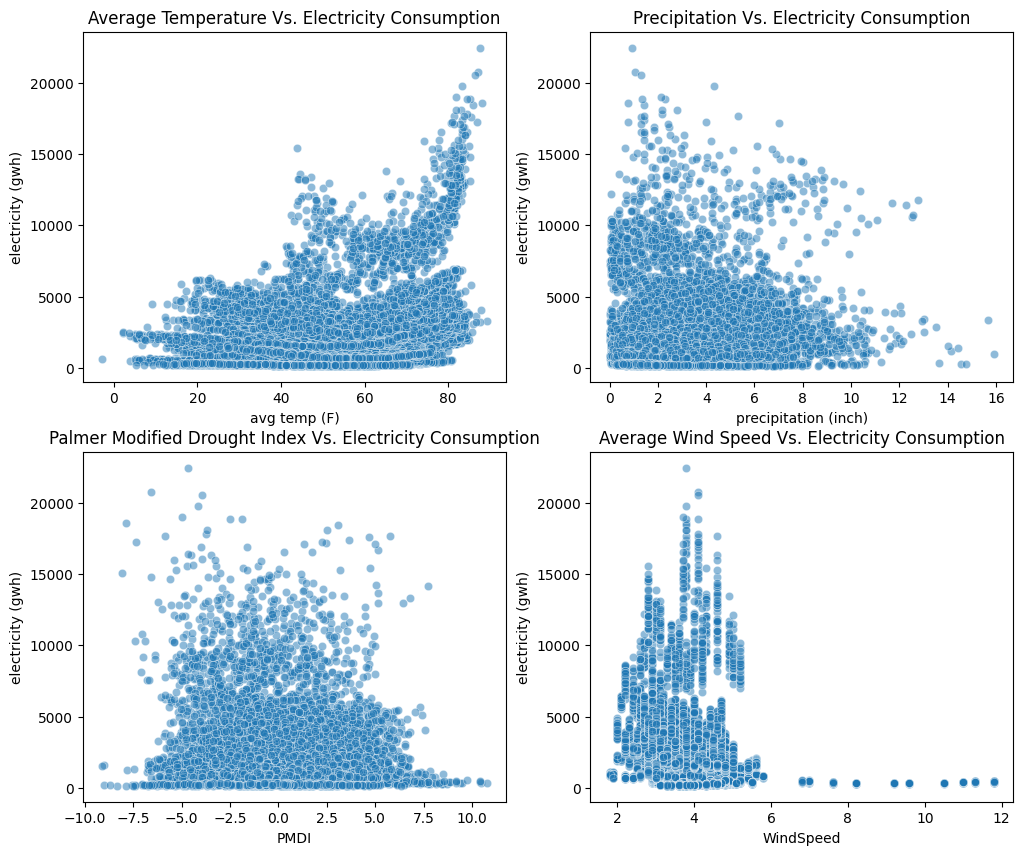

In [55]:
fig, axes = plt.subplots(2,2,figsize=(12,10))
axes = axes.flatten()

sns.scatterplot(x="avg temp (F)", y="electricity (gwh)", data = data, alpha=0.5,ax=axes[0])
axes[0].set_title("Average Temperature Vs. Electricity Consumption")

sns.scatterplot(x="precipitation (inch)", y="electricity (gwh)", data = data, alpha=0.5, ax=axes[1])
axes[1].set_title("Precipitation Vs. Electricity Consumption")

sns.scatterplot(x="PMDI", y="electricity (gwh)", data = data, alpha=0.5, ax=axes[2])
axes[2].set_title("Palmer Modified Drought Index Vs. Electricity Consumption")

sns.scatterplot(x="WindSpeed", y="electricity (gwh)", data = data, alpha=0.5, ax=axes[3])
axes[3].set_title("Average Wind Speed Vs. Electricity Consumption")

plt.show()

**[Observation]**
- Overall, the relationships appear weak and where relationships exist they tend to be nonlinear rather than linear.
- While weather alone may not fully explain electricity consumption, understanding its contribution is still valuable.
- Given the nonlinear patterns, nonparametric models are expected to perform better than GLMs.

## 3.4. Electricity Consumption Distribution

Examined the distribution of the target variable to identify skewness and the need for potential transformation.


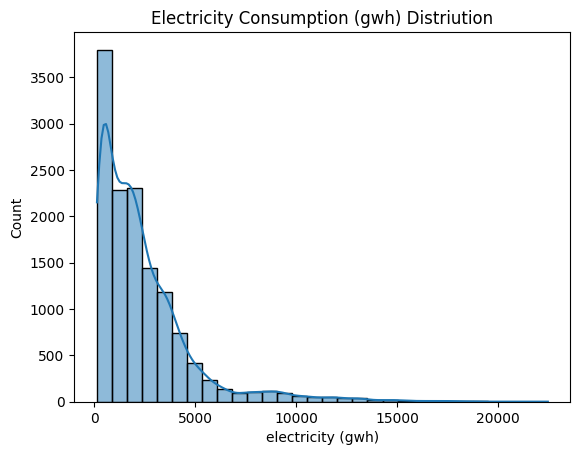

In [56]:
sns.histplot(data["electricity (gwh)"], bins=30,kde=True)
plt.title("Electricity Consumption (gwh) Distriution")
plt.show()

**[Observation]**
- The distribution of residential electricity consumption is right skewed as a few states show much higher consumption levels than others.


# 4. Modeling Part 1. Interpretation

In this part, as the goal is interpretation, we restricted the model to weather and season related features only in order to interpret and understand how they affect electricity consumption.

## 4.1. Log Transformation & Z-score Scaling
- Log Transformation
  - The target variable was right skewed, so log transformaton was applied to reduce skewness and make relationships easier for models to capture.
- Z-score Standardization
  - Standardized electricity consumption by state to remove baseline differences across states.
  - This allows us to interpret the effect of weather features independent of state size or population.

In [57]:
z_data = data.copy()

In [58]:
z_data["electricity_log"] = np.log1p(z_data["electricity (gwh)"])

In [59]:
z_data["electricity_y(gwh)"] = z_data.groupby("state")["electricity_log"].transform(lambda e: (e-e.mean())/e.std())

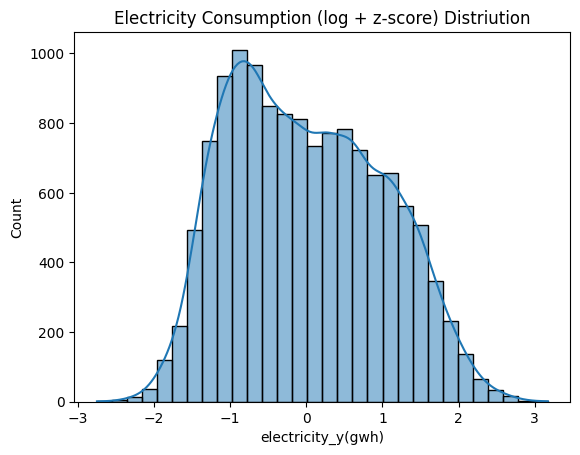

In [60]:
sns.histplot(z_data["electricity_y(gwh)"],bins=30,kde=True)
plt.title("Electricity Consumption (log + z-score) Distriution")
plt.show()

**[Observation]**
- After applying log transformation and stadardization, the target distribution becomes much closer to normal distribution.
- This reduces the influence of states with extreme high consumption and improves model interpretability.

## 4.2. Train Test Split (Time Series)
- Electricity consumption and weather features are time dependent.
- Random splitting can cause data leakage.
- We set 2020 as the cutoff year to ensure that both train and test sets include part of the COVID-19 period, which may have affected electricity consumption.

In [61]:
interpret = ["avg temp (F)","WindSpeed","precipitation (inch)","PMDI","month_sin","month_cos"]
X = z_data[interpret]
y = z_data['electricity_y(gwh)']

In [62]:
train_2020 = z_data["Year"]<=2020
test_2021 = z_data["Year"]>=2021
X_train, X_test = X[train_2020], X[test_2021]
y_train, y_test = y[train_2020], y[test_2021]

## 4.3. Metrics
- Root Mean Squared Error (RMSE)
  - Measures how far the model's predictions deviate from actual values.
- R-squared ($R^2$)
  - Represents the proportion of variance in electricity consumption explained by the model.

In [63]:
def metrics(true_y, pred_y):
  rmse = np.sqrt(mean_squared_error(true_y, pred_y))
  r2 = r2_score(true_y, pred_y)
  return rmse, r2

## 4.4. Parametric: Gaussian GLM (with Z-score)
- **Gaussian Link Function**
  - $g(u) = X\beta$
  - identity function: $u = X\beta$ which indiates that predicted value from the regression is just the expected value of y
  - $\text{Electricity consumption}
     = \beta_0 + \beta_1\text{temp} + \beta_2\text{pr} + \beta_3\text{PMDI} + \beta_4\text{wind} + \beta_5\text{month sin} + \beta_6\text{month cos}+\epsilon$

  - Assume error term ($\epsilon$) to be normally distributed.



In [64]:
train_df = z_data[train_2020]
train_df = train_df.rename(columns={"electricity (gwh)": "electricity_gwh","electricity_y(gwh)": "electricity_y_gwh",
                                    "avg temp (F)": "avg_temp_F","WindSpeed": "avg_wind_mph"})

In [65]:
interpret = ["avg_temp_F","avg_wind_mph","precipitation (inch)","PMDI","month_sin","month_cos"]
X = train_df[interpret]
X = sm.add_constant(X)
y = train_df["electricity_y_gwh"]
lr = sm.GLM(y, X, family=sm.families.Gaussian())
lr_result = lr.fit()

### 4.4.1. Check Error Term Assumption

Is error term normally distributed?
- Residual distribution graph
- Quantile-Quantile (Q-Q) plot

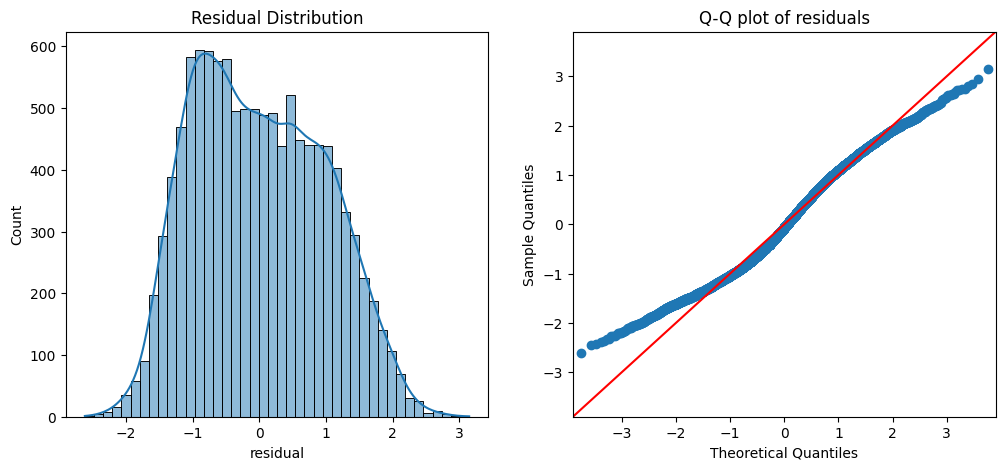

In [66]:
gaussian_residual = lr_result.resid_response
fig, axes = plt.subplots(1,2, figsize = (12,5))
sns.histplot(gaussian_residual, kde=True, ax=axes[0])
axes[0].set_title("Residual Distribution")
axes[0].set_xlabel("residual")

sm.qqplot(gaussian_residual, line="45", ax=axes[1])
axes[1].set_title("Q-Q plot of residuals")
plt.show()

**[Observation]**
- The normality assumption of the Gaussian GLM is not fully satisfied.
- Q-Q plot
  -  If residuals were perfectly normal, points would lie along the 45 degree reference line.
  - Lower quantiles bend upward and upper quantiles bend downward, indicates lighter tails and more concentration near the center than expected under normality.

### 4.4.2. Gaussian Summary & Results

In [67]:
print(lr_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      electricity_y_gwh   No. Observations:                11520
Model:                            GLM   Df Residuals:                    11513
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                         0.95126
Method:                          IRLS   Log-Likelihood:                -16055.
Date:                Sun, 09 Nov 2025   Deviance:                       10952.
Time:                        17:11:27   Pearson chi2:                 1.10e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03156
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.8056 

In [68]:
test_df = z_data[test_2021]
test_df = test_df.rename(columns={"electricity (gwh)": "electricity_gwh","electricity_y(gwh)": "electricity_y_gwh",
                                  "avg temp (F)": "avg_temp_F","WindSpeed": "avg_wind_mph"})

In [69]:
y_test = test_df["electricity_y_gwh"]
y_pred = lr_result.predict(sm.add_constant(test_df[interpret]))

gau_rmse, gau_r2 = metrics(y_test, y_pred)
print(f"Guassian test RMSE: {gau_rmse:.3f}")
print(f'Guassian test R^2: {gau_r2:.3f}')

Guassian test RMSE: 1.049
Guassian test R^2: -0.114


### **[Gaussian Interpretation]**
- $R^2$: Train: 0.03156, Test: -0.114
  - Slight positive train $R^2$ indicates minimal pattern capture.
  - Negative test $R^2$ indicates the model performs worse than a mean baseline.

- RMSE: Test:1.049
  - This indicates that predictions deviate by roughly one standard deviation in the standardized scale which is large.

- P-value, Confidence Interval, Coefficients
  - As residuals are not norally distributed, p-values and confidence interval may be unreliable and biased.
  - Coeficient signs offer some directional insight, but effects are small
  - As seen in EDA, weather and electricity consumption relationships are nonlinear, so weak performance is expected. Results should be interpreted with caution.

## 4.5. Parametric: Gamma GLM (with Original Electricity Consumption)
- **Gamma Distribution**
  - log link function: $g(u) = log(u) = X\beta$
  - $log(u) = \beta_0 + \beta_1\text{temp} + \beta_2\text{pr} + \beta_3\text{PMDI} + \beta_4\text{wind} + \beta_5\text{sin} + \beta_6\text{cos} + \epsilon$

  - Gamma is more appropriate for right skewed positive targets.

  - Since Gamma assumes a positive target and uses a log link, the target should not be z-score standardized or log-transformed before modeling.

In [70]:
o_data = data.copy()
o_data = o_data.rename(columns={"electricity (gwh)": "electricity_gwh",
                                "avg temp (F)": "avg_temp_F",
                                "WindSpeed": "avg_wind_mph",
                                "lag_1(gwh)": "lag_1_gwh",
                                "lag_12(gwh)": "lag_12_gwh"})

In [71]:
interpret = ["avg_temp_F", "avg_wind_mph", "precipitation (inch)", "PMDI", "month_sin", "month_cos"]
X = o_data[interpret]
y = o_data["electricity_gwh"]

In [72]:
train_2020 = o_data["Year"]<=2020
test_2021 = o_data["Year"]>=2021

In [73]:
X = sm.add_constant(X)

X_train_g, X_test_g = X[train_2020], X[test_2021]
y_train_g, y_test_g = y[train_2020], y[test_2021]

gm = sm.GLM(y_train_g, X_train_g, family=sm.families.Gamma(link=sm.families.links.Log()))
gm_result = gm.fit()
print(gm_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        electricity_gwh   No. Observations:                11520
Model:                            GLM   Df Residuals:                    11513
Model Family:                   Gamma   Df Model:                            6
Link Function:                    Log   Scale:                         0.72603
Method:                          IRLS   Log-Likelihood:                -99106.
Date:                Sun, 09 Nov 2025   Deviance:                       7885.4
Time:                        17:11:28   Pearson chi2:                 8.36e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.2759
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.8617 

In [74]:
y_pred_test = gm_result.predict(X_test_g)
y_pred_train = gm_result.predict(X_train_g)
rmse_test, ga_r2 = metrics(y_test_g, y_pred_test)
rmse_train = np.sqrt(mean_squared_error(y_train_g, y_pred_train))
print(f"Gamma Train standardized RMSE: {rmse_train/y_train_g.std():.3f}")
print(f"Gamma Test standardized RMSE: {rmse_test/y_test_g.std():.3f}")
print(f"Gamma Test R^2: {ga_r2:.3f}")

Gamma Train standardized RMSE: 0.885
Gamma Test standardized RMSE: 0.891
Gamma Test R^2: 0.206


### **[Gamma Interpretation]**
- $R^2$: Train: 0.2759, Test: 0.206
  - Performs significantly better than Gaussian GLM (Test $R^2$ = -0.114), indicating it explains more variability as expected for a skewed target.
  - However, still substantial portion of variation reamins unexplained, likely due to nonlinear relationships or other important features not included in the model.

- RMSE: Test:0.891
  - Results are standardized for comparison with Gaussian GLM.
  - Lower RSME than Gaussian (1.049), indicating more stable and appropriate modeling for the right skewed distribution.
  - Still relatively high, as Gamma GLM is limited by its linear structure while the relationships are nonlinear.

- P-value, Confidence Interval, Coefficients
  - All features except precipitation are statistically significant, indicating weather and seasonal variables do influence electricity consumption.
  - Although the results are more stable than gaussian, interpretation should still be cautious, because nonlinear relationships may bias coefficient interpretation even when it is seem as significant.


## 4.6. Nonparametric: RandomForest (z-score)
- The same dataset (log + z socre) used to ensure a proper comparison against parametric models.
- Unlike GLMs, Random Forest does not provide coefficients. Instead, it provides feature importance, indicating how much each feature contributes to prediction.

### 4.6.1. Basic Model
- A basic Random Forest model was trained without any constraints or hyperparameter tuning.
- Only random_state = 42 was applied to ensure reproductibitity and allow proper comparison.

In [75]:
base_rf = RandomForestRegressor(random_state=42)
base_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [76]:
b_rf_pred = base_rf.predict(X_test)
b_rf_rmse, b_rf_r2 = metrics(y_test, b_rf_pred)
base_train_pred = base_rf.predict(X_train)
train_b_rf_rmse, train_b_rf_r2 = metrics(y_train, base_train_pred)

print("Without Constraints (basic model):")
print(f"   Train set RMSE without constraints: {train_b_rf_rmse:.3f}")
print(f"   Test set RMSE without constraints: {b_rf_rmse:.3f}")
print(f"   R^2: {b_rf_r2:.3f}")

Without Constraints (basic model):
   Train set RMSE without constraints: 0.168
   Test set RMSE without constraints: 0.577
   R^2: 0.663


In [77]:
# Cross validation
cv_data = z_data.sort_values(["Year","Month"])
time = cv_data[["Year", "Month"]].drop_duplicates().reset_index(drop=True)

print("Without Constraints (basic model):")

tss = TimeSeriesSplit(n_splits=3)
n = 1
cv_result = []

for train, test in tss.split(time):
  train_time = time.iloc[train]
  test_time = time.iloc[test]

  train_df = cv_data.merge(train_time, on = ["Year", "Month"])
  test_df = cv_data.merge(test_time, on = ["Year", "Month"])

  train_df = train_df.rename(columns={
      "electricity (gwh)": "electricity_gwh",
      "electricity_y(gwh)": "electricity_y_gwh",
      "avg temp (F)": "avg_temp_F",
      "WindSpeed": "avg_wind_mph"
  })
  test_df = test_df.rename(columns={
      "electricity (gwh)": "electricity_gwh",
      "electricity_y(gwh)": "electricity_y_gwh",
      "avg temp (F)": "avg_temp_F",
      "WindSpeed": "avg_wind_mph"
  })


  cv_b_x_train, cv_b_x_test = train_df[interpret], test_df[interpret]
  cv_b_y_train, cv_b_y_test = train_df["electricity_y_gwh"], test_df["electricity_y_gwh"]
  base_rf = RandomForestRegressor(random_state=42)
  base_rf.fit(cv_b_x_train, cv_b_y_train)
  base_pred = base_rf.predict(cv_b_x_test)
  test_rmse, test_r2 = metrics(cv_b_y_test, base_pred)
  cv_result.append(test_rmse)
  print(f"   CV{n} RMSE: {test_rmse:.3f}")
  n+=1

print(f"   CV mean RMSE: {np.mean(cv_result):.3f}")

Without Constraints (basic model):
   CV1 RMSE: 0.566
   CV2 RMSE: 0.486
   CV3 RMSE: 0.574
   CV mean RMSE: 0.542


### **[Random Forest Basic Model Interpretation]**
Train set RMSE: 0.168 | Test set RMSE: 0.577 | CV test mean RMSE: 0.542 | $R^2$: 0.663
- Compared to the Gamma GLM (test RMSE: 0.891), basic Random Forest shows a significant improvement.
- Large gap between train set RMSE and test set RMSE indicates overfitting.
- Test set RMSE and CV test mean RMSE are similar, indicating predictions are relatively stable despite overfitting.


### 4.6.2. Hyperparameter Tuning
To reduce overfitting and improve predictive performance, Random Forest was tuned using using RandomizedSearchCV with neg_root_mean_squared_error as the scoring metric.

In [78]:
cv_train_data = z_data[train_2020].sort_values(["Year","Month"])
time = cv_train_data[["Year", "Month"]].drop_duplicates().reset_index(drop=True)
tss = TimeSeriesSplit(n_splits=3)

param = {"max_depth": [None, 5, 10, 15, 20],
         "n_estimators": [100,200,300,400,500],
         "max_features": ["sqrt","log2"],
         "min_samples_leaf": [3,5,7,10]}

fold = []
for train, test in tss.split(time):
  train_time = time.iloc[train]
  test_time = time.iloc[test]
  tr_fold = cv_train_data.merge(train_time, on = ["Year", "Month"])
  te_fold = cv_train_data.merge(test_time, on = ["Year", "Month"])
  fold.append((tr_fold.index, te_fold.index))

adv_rf = RandomForestRegressor(random_state=42)

rs = RandomizedSearchCV(adv_rf,param, n_iter = 30, cv=fold,scoring="neg_root_mean_squared_error",random_state=42,n_jobs=-1)
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=[(RangeIndex(start=0, stop=2880, step=1),
                        RangeIndex(start=0, stop=2880, step=1)),
                       (RangeIndex(start=0, stop=5760, step=1),
                        RangeIndex(start=0, stop=2880, step=1)),
                       (RangeIndex(start=0, stop=8640, step=1),
                        RangeIndex(start=0, stop=2880, step=1))],
                   estimator=RandomForestRegressor(random_state=42), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [3, 5, 7, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [79]:
print(f"Best CV RMSE: {np.sqrt(-rs.best_score_):.3f}")

Best CV RMSE: 0.552


In [80]:
rf_best = rs.best_estimator_
rf_best.fit(X_train, y_train)
best_pred = rf_best.predict(X_test)
best_rmse,best_r2 = metrics(y_test, best_pred)
rs_train_pred = rf_best.predict(X_train)
adv_train_rmse, adv_train_r2 = metrics(y_train, rs_train_pred)

print("WIth Constraints (advanced model): ")
print(f"   Train set RMSE with constraints: {adv_train_rmse:.3f}")
print(f"   Test set RMSE with constraints: {best_rmse:.3f}")
print(f"   R^2: {best_r2:.3f}")

WIth Constraints (advanced model): 
   Train set RMSE with constraints: 0.302
   Test set RMSE with constraints: 0.568
   R^2: 0.674


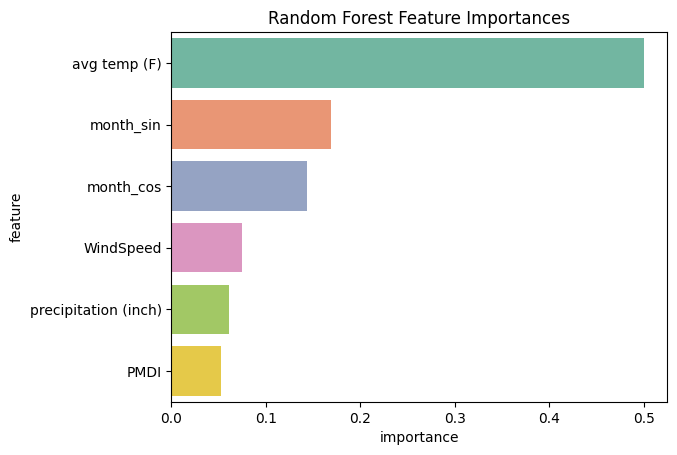

In [81]:
importances = rf_best.feature_importances_
feature = X_train.columns
fi_data = pd.DataFrame({"feature": feature,"importance": importances}).sort_values(by="importance", ascending = False)

sns.barplot(data=fi_data, x="importance", y="feature", palette="Set2",hue="feature")
plt.title("Random Forest Feature Importances")
plt.show()

### **[Random Forest tuned Model Interpretation]**
Train set RMSE: 0.302 | Test set RMSE: 0.568 | $R^2$: 0.674
- Overfitting decreased as the gap between train and test RMSE decreased compared to basic model.
- Test performance improved slightly, but the improvement is modest, likely because the model is still limited to weather and seasonal features only.
- Both basic and tuned model results suggest that around $R^2$ = 0.68 may be the upper limit when relying soley on weather and seasonal features.

Feature Importance
- Average temperature is the most influential feature, contributing approximately 50% of the total importance.
- Other weather features each contribute less than 10%, indicating limited influence on electricity consumption.

## 4.7. Deeper insight into Temperature Effects (HDD, CDD)
- Average temperatue was identified as the most effective among weather features.
- However, average temperature alone cannot distinguish between cold and hot conditions.
- To gain deeper interpretability, temperature was decomposed:
  - Heating Degree Days (HDD): how much the daily average temperature falls below 65 degree
  - Cooling Degree Days (CDD): how much it exceeds 65 degree

In [82]:
extra = z_data.copy()

In [83]:
extra["HDD"] = np.maximum(0, 65-extra["avg temp (F)"])
extra["CDD"] = np.maximum(0, extra["avg temp (F)"]-65)

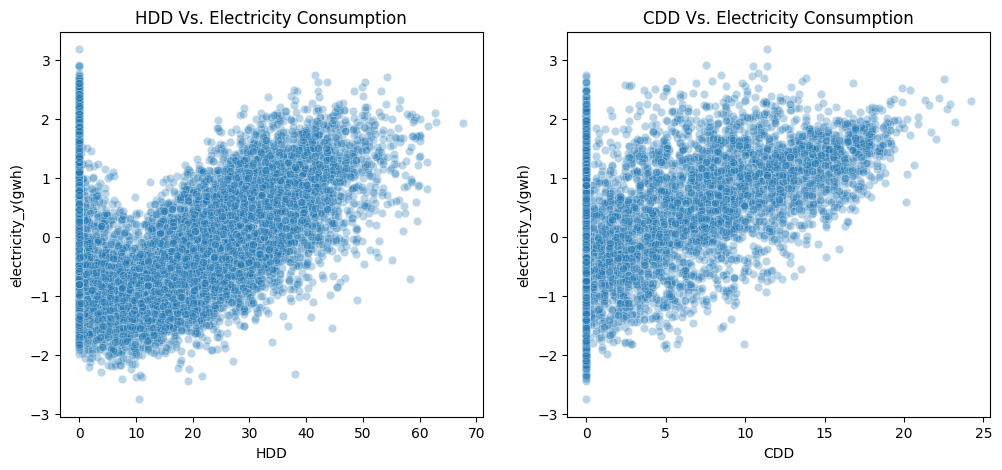

In [84]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x="HDD", y="electricity_y(gwh)", data=extra,alpha=0.3, ax=axes[0])
axes[0].set_title("HDD Vs. Electricity Consumption")

sns.scatterplot(x="CDD", y="electricity_y(gwh)", data=extra,alpha=0.3, ax=axes[1])
axes[1].set_title("CDD Vs. Electricity Consumption")
plt.show()

**[Observations]**
- Both scatter HDD and CDD show a positive relationship with electricity consmption.
- As HDD increases, electricity consumption rises due to higher heating demand in cold months.
- As CDD increases, electricity consumption rises due to higher cooling demand in hot months.


In [85]:
extra_interpret = ["HDD", "CDD", "WindSpeed", "precipitation (inch)", "PMDI", "month_sin", "month_cos"]
X_e = extra[extra_interpret]
y_e = extra["electricity_y(gwh)"]

X_train, X_test = X_e[train_2020], X_e[test_2021]
y_train, y_test = y_e[train_2020], y_e[test_2021]

In [86]:
e_rf = RandomForestRegressor(random_state=42)
e_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [87]:
e_pred = e_rf.predict(X_test)
e_rmse, e_r2 = metrics(y_test, e_pred)
e_train_pred = e_rf.predict(X_train)
train_e_rmse, train_e_r2 = metrics(y_train, e_train_pred)

print("Without Constraints (basic model):")
print(f"   Train set RMSE without constraints: {train_e_rmse:.3f}")
print(f"   Test set RMSE without constraints: {e_rmse:.3f}")
print(f"   R^2: {e_r2:.3f}")

Without Constraints (basic model):
   Train set RMSE without constraints: 0.168
   Test set RMSE without constraints: 0.577
   R^2: 0.663


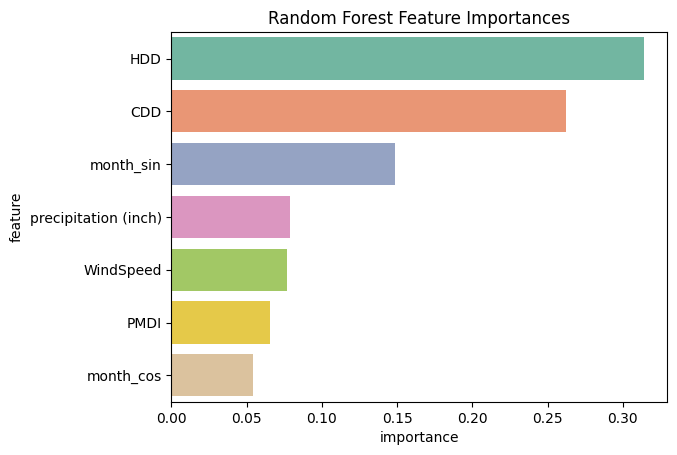

In [88]:
e_importances = e_rf.feature_importances_
feature = X_train.columns
fi_data = pd.DataFrame({"feature": feature,"importance": e_importances}).sort_values(by="importance", ascending = False)

sns.barplot(data=fi_data, x="importance", y="feature", palette="Set2",hue="feature")
plt.title("Random Forest Feature Importances")
plt.show()

### **[Insight to Temperature Effects]**
Train RMSE: 0.168 | Test RMSE: 0.577 | $R^2$: 0.663
- Performance remains the same as the basic Random Forest model using average temperature because HDD and CDD carry essentially the same information, and the model already captures the nonlinear temperature effect.
- However, splitting average temperature into two variables enhance interpretability, as it allows us to separately capture the effects of HDD and CDD.




# 5. Interpretation: Final Results
- Weather and seasonality do influence electricity consumption, but the relationship is nonliear, which led to high RMSE and low $R^2$ for GLM models.
  - Gaussian GLM performed poorly because the residuals did not meet the normality assumption.
  - Gamma GLM performed better and aligned with the right skewed target distribution but still showed limited explanation.

- Random Forest significantly improved pridictive performance, showing its strength in capturing nonlinear relationships between weather/seasonal features and electricity consumption.

- Average Temperature is the most influential weather feature affecting electricity consumption.
  - Decomposing temperature into HDD and CDD improves interpretability, clearly showing that both cooling and heating increase electricity consumption.
  - This also makes the insights more actionable, as HDD and CDD directly translate into real world energy demand patterns useful for utility planning and climate related policy.
- Other weather features showed relatively weak effects, each contributing less than 10% importance.
- Model performance shows diminishing returns around $R^2$ = 0.67, suggesting that weather and seasonality alone cannot fully explain electricity consumption, though they still provide meaningful predictive value.
  - To further improve predictive performance, additional variables should be added.